In [5]:
# -*- coding: utf-8 -*-
"""
Created on Fri 21 2020
@author: Thiago Pinho
"""

# -*- coding: utf-8 -*-
"""
Created on Fri 21 2020
@author: Thiago Pinho
"""

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import spacy

VECTOR_MODEL_NAME = 'pt_core_news_sm'
RELATIVE_PATH_TO_CSV = "./assets/datasets/ribon/Feeds_Label.csv"

# load the dataset
df_ribon_news = pd.read_csv(RELATIVE_PATH_TO_CSV)
print(df_ribon_news.head())

   id  pick_count                                            content  \
0  11           0  A forte ligação dos cães com o ser humano desp...   
1  12           0  Os chamados muros da gentileza estão promovend...   
2   9           0  Alguns de nós sabem a sorte que é ter um irmão...   
3   6           0               Temos muito o que aprender com elas.   
4   1           0  Esqueça o que te disseram sobre a zona de conf...   

                                               title    Label_Train  
0  Há mais de 10 anos, dupla de cães 🐶 acompanha ...        Animais  
1  Muros da gentileza ajudam desabrigados e famíl...  Solidariedade  
2  20 fotos maravilhosas mostrando a alegria de t...        Familia  
3  13 razões pelas quais crianças são bem mais es...       Criancas  
4  Ex-executiva fala sobre vida sem propósito - I...      Proposito  


In [6]:
df_ribon_news.columns = map(lambda x: str(x).upper(), df_ribon_news.columns)
df_ribon_news['LABEL_TRAIN'] = df_ribon_news['LABEL_TRAIN'].str.upper()
''' Converting all labels to uppercase '''
print(df_ribon_news.head())

   ID  PICK_COUNT                                            CONTENT  \
0  11           0  A forte ligação dos cães com o ser humano desp...   
1  12           0  Os chamados muros da gentileza estão promovend...   
2   9           0  Alguns de nós sabem a sorte que é ter um irmão...   
3   6           0               Temos muito o que aprender com elas.   
4   1           0  Esqueça o que te disseram sobre a zona de conf...   

                                               TITLE    LABEL_TRAIN  
0  Há mais de 10 anos, dupla de cães 🐶 acompanha ...        ANIMAIS  
1  Muros da gentileza ajudam desabrigados e famíl...  SOLIDARIEDADE  
2  20 fotos maravilhosas mostrando a alegria de t...        FAMILIA  
3  13 razões pelas quais crianças são bem mais es...       CRIANCAS  
4  Ex-executiva fala sobre vida sem propósito - I...      PROPOSITO  


In [7]:
# Viewing frequencies
for label in df_ribon_news['LABEL_TRAIN'].unique():
    print(label + ": ", len(df_ribon_news[df_ribon_news.LABEL_TRAIN == label]))


ANIMAIS:  67
SOLIDARIEDADE:  94
FAMILIA:  19
CRIANCAS:  19
PROPOSITO:  86
DIVERSIDADE:  72
EDUCACAO:  66
ECOLOGIA:  129
SAUDE:  24
IDOSOS:  15
CIENCIA:  31
CELEBRACAO:  56
ETNIAS:  65
ESPORTE:  34
CULTURA:  79
EMPREENDEDORISMO:  32


In [25]:
# For simple label encoding
# All categorical columns
categorical_cols = ['LABEL_TRAIN']

label_df_ribon_news = df_ribon_news

# Apply label encoder
label_encoder = LabelEncoder()
for col in categorical_cols:
    label_df_ribon_news[col] = label_encoder.fit_transform(df_ribon_news[col])

print(label_df_ribon_news.head())

   ID  PICK_COUNT                                            CONTENT  \
0  11           0  A forte ligação dos cães com o ser humano desp...   
1  12           0  Os chamados muros da gentileza estão promovend...   
2   9           0  Alguns de nós sabem a sorte que é ter um irmão...   
3   6           0               Temos muito o que aprender com elas.   
4   1           0  Esqueça o que te disseram sobre a zona de conf...   

                                               TITLE  LABEL_TRAIN  
0  Há mais de 10 anos, dupla de cães 🐶 acompanha ...            0  
1  Muros da gentileza ajudam desabrigados e famíl...           15  
2  20 fotos maravilhosas mostrando a alegria de t...           11  
3  13 razões pelas quais crianças são bem mais es...            3  
4  Ex-executiva fala sobre vida sem propósito - I...           13  


In [9]:
# Load the large model to get the vectors
nlp = spacy.load(VECTOR_MODEL_NAME)

# We just want the vectors so we can turn off other models in the pipeline
with nlp.disable_pipes():
    vectors = np.array([nlp(str(news.CONTENT)).vector for idx, news in df_ribon_news.iterrows()])
    
print(vectors.shape)


(888, 96)


In [74]:
# Training models

X_train, X_test, y_train, y_test = train_test_split(vectors, label_df_ribon_news.LABEL_TRAIN, 
                                                      test_size=0.33,
                                                          random_state=42)

# Create the LinearSVC model
model = LinearSVC(random_state=1, dual=False)
#Fit the model
model.fit(X_train, y_train)

# Uncomment and run to see model accuracy
print(f'Model test accuracy: {model.score(X_test, y_test)*100:.3f}%')

Model test accuracy: 17.687%


In [67]:
# Scratch space in case you want to experiment with other models

second_model = RandomForestRegressor(random_state=2)
second_model.fit(X_train, y_train)
print(f'Model test accuracy: {second_model.score(X_test, y_test)*100:.3f}%')

Model test accuracy: 0.458%


In [80]:
from xgboost import XGBRegressor

# Define the model
my_model_3 = XGBRegressor(n_estimators=1000, learning_rate=0.025, n_jobs=4, max_depth=12)

# Fit the model
my_model_3.fit(X_train, y_train, 
             early_stopping_rounds=100, 
             eval_set=[(X_test, y_test)], 
             verbose=False)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.025, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [82]:
# Uncomment and run to see model accuracy
print(f'Model test accuracy: {my_model_3.score(X_test, y_test)*100:.3f}%')

Model test accuracy: -9.236%


In [85]:
help(my_model_3.score)

Help on method score in module sklearn.base:

score(X, y, sample_weight=None) method of xgboost.sklearn.XGBRegressor instance
    Return the coefficient of determination R^2 of the prediction.
    
    The coefficient R^2 is defined as (1 - u/v), where u is the residual
    sum of squares ((y_true - y_pred) ** 2).sum() and v is the total
    sum of squares ((y_true - y_true.mean()) ** 2).sum().
    The best possible score is 1.0 and it can be negative (because the
    model can be arbitrarily worse). A constant model that always
    predicts the expected value of y, disregarding the input features,
    would get a R^2 score of 0.0.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Test samples. For some estimators this may be a
        precomputed kernel matrix or a list of generic objects instead,
        shape = (n_samples, n_samples_fitted),
        where n_samples_fitted is the number of
        samples used in the fitting for the estima

In [144]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import string
import re
from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('portuguese')
print(stopwords)

['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estiv

In [111]:
TARGET_VARIABLE = 'LABEL_TRAIN'
TEXT_VARIABLE = 'TITLE'

In [112]:
TARGET_VARIABLE = 'LABEL_TRAIN'
TEXT_VARIABLE = 'TITLE'

from sklearn.model_selection import train_test_split
print(df_ribon_news.columns)
train, test = train_test_split(df_ribon_news[[TARGET_VARIABLE, TEXT_VARIABLE]], 
                                                      test_size=0.33,
                                                          random_state=42)
print('Research title sample:', train[TEXT_VARIABLE].iloc[0])
print('Conference of this paper:', train[TARGET_VARIABLE].iloc[0])
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)


Index(['ID', 'PICK_COUNT', 'CONTENT', 'TITLE', 'LABEL_TRAIN'], dtype='object')
Research title sample: Conheça a PHC
Conference of this paper: PROPOSITO
Training Data Shape: (594, 2)
Testing Data Shape: (294, 2)


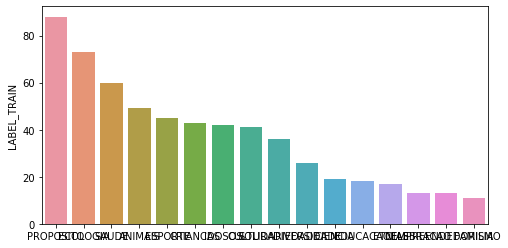

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [114]:
fig = plt.figure(figsize=(8,4))
sns.barplot(x = train[TARGET_VARIABLE].unique(), y=train[TARGET_VARIABLE].value_counts())
plt.show()

punctuations = string.punctuation
print(punctuations)

In [145]:
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

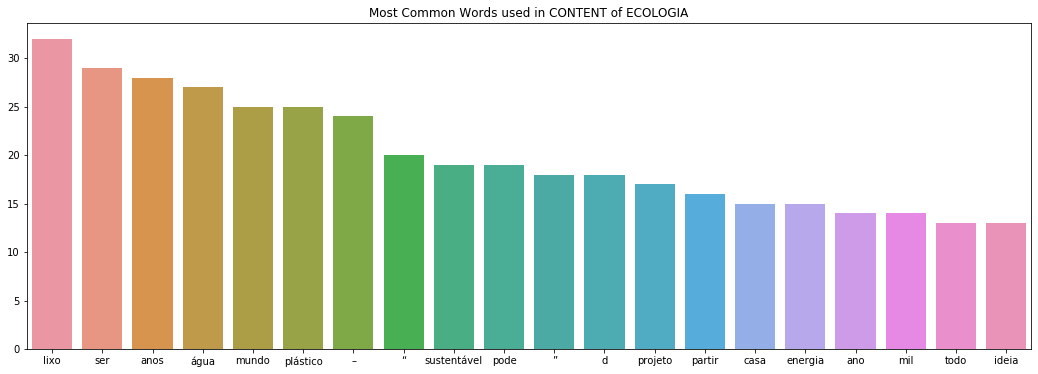

In [146]:
most_common_target_label = train[TARGET_VARIABLE].value_counts().idxmax()

most_common_target_text = [text for text in train[train[TARGET_VARIABLE] == most_common_target_label][TEXT_VARIABLE]]
most_common_target_clean = cleanup_text(most_common_target_text)
most_common_target_clean = ' '.join(most_common_target_clean).split()
most_common_target_counts = Counter(most_common_target_clean)
most_common_target_common_words = [word[0] for word in most_common_target_counts.most_common(20)]
most_common_target_common_counts = [word[1] for word in most_common_target_counts.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=most_common_target_common_words, y=most_common_target_common_counts)
plt.title('Most Common Words used in ' + TEXT_VARIABLE + ' of ' + most_common_target_label)
plt.show()

In [132]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
import string
import re
from spacy.lang.pt import Portuguese
parser = Portuguese()

STOPLIST = set(stopwords.words('portuguese'))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]
print(STOPLIST)
print(SYMBOLS)

{'estive', 'este', 'tuas', 'só', 'fora', 'esse', 'com', 'houverei', 'ou', 'tua', 'da', 'aquele', 'que', 'essa', 'vocês', 'tive', 'lhes', 'sejam', 'tivera', 'se', 'aos', 'nós', 'tiverem', 'mais', 'tu', 'serei', 'éramos', 'estivermos', 'hei', 'tenho', 'fossem', 'tivessem', 'teriam', 'tenhamos', 'ao', 'tínhamos', 'delas', 'estou', 'nossa', 'tém', 'deles', 'é', 'seríamos', 'fosse', 'você', 'sejamos', 'meu', 'num', 'houveria', 'das', 'quem', 'está', 'houvessem', 'mas', 'pelos', 'seremos', 'estava', 'qual', 'como', 'mesmo', 'minhas', 'estes', 'dela', 'numa', 'houvéramos', 'tiveram', 'nos', 'tenham', 'estas', 'houvéssemos', 'esta', 'não', 'estejamos', 'houvesse', 'do', 'quando', 'foi', 'teu', 'eram', 'hajam', 'seja', 'estão', 'tinham', 'ele', 'tinha', 'são', 'houverem', 'estivessem', 'estamos', 'há', 'a', 'essas', 'nosso', 'havemos', 'isto', 'houveram', 'teve', 'nossas', 'estavam', 'haja', 'as', 'estivemos', 'estivéssemos', 'teria', 'esteve', 'lhe', 'houveríamos', 'houvermos', 'terão', 'houve

In [149]:
class CleanTextTransformer(TransformerMixin):
   def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
   def fit(self, X, y=None, **fit_params):
        return self
def get_params(self, deep=True):
        return {}
    
def cleanText(text):
    text = str(text)
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text
def tokenizeText(sample):
    tokens = parser(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens


def printNMostInformative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)

In [134]:
vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,1))
clf = LinearSVC()

pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])
# data
train1 = train[TEXT_VARIABLE].tolist()
labelsTrain1 = train[TARGET_VARIABLE].tolist()
test1 = test[TEXT_VARIABLE].tolist()
labelsTest1 = test[TARGET_VARIABLE].tolist()
# train
pipe.fit(train1, labelsTrain1)
# test
preds = pipe.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print("Top 10 features used to predict: ")
printNMostInformative(vectorizer, clf, 10)

accuracy: 0.38095238095238093
Top 10 features used to predict: 
Class 1 best: 
(-0.1897694316894422, 'bióloga')
(-0.16352729068014382, 'crianças')
(-0.16040121422287903, 'podem')
(-0.15355964850990578, 'prêmio')
(-0.1485849282984244, 'ganha')
(-0.14133043547232513, 'alimentos')
(-0.13149105459040034, 'designer')
(-0.1306967924936315, 'brasileira')
(-0.1306967924936315, 'evitar')
(-0.1306967924936315, 'internacional')
Class 2 best: 
(0.8801639144445821, 'animais')
(0.8208038382932755, 'cães')
(0.6095894832153419, 'elefantes')
(0.6064773450557794, 'generosidade')
(0.5963559602810411, 'abandonados')
(0.5328491271379163, 'elefanta')
(0.5278134621478181, 'cãozinho')
(0.5004308527946235, 'zoológico')
(0.49365834443018985, 'menos')
(0.48907624780393616, 'cadela')


In [136]:
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer)])
transform = pipe.fit_transform(train1, labelsTrain1)
vocab = vectorizer.get_feature_names()
for i in range(len(train1)):
    s = ""
    indexIntoVocab = transform.indices[transform.indptr[i]:transform.indptr[i+1]]
    numOccurences = transform.data[transform.indptr[i]:transform.indptr[i+1]]
    for idx, num in zip(indexIntoVocab, numOccurences):
        s += str((vocab[idx], num))
        
from sklearn import metrics
print(metrics.classification_report(labelsTest1, preds, 
                                    target_names=df_ribon_news[TARGET_VARIABLE].unique()))

                  precision    recall  f1-score   support

         ANIMAIS       0.44      0.31      0.36        26
   SOLIDARIEDADE       0.33      0.35      0.34        20
         FAMILIA       0.33      0.17      0.22        12
        CRIANCAS       0.00      0.00      0.00         6
       PROPOSITO       0.50      0.27      0.35        30
     DIVERSIDADE       0.36      0.33      0.35        27
        EDUCACAO       0.43      0.68      0.53        41
        ECOLOGIA       0.47      0.39      0.43        23
           SAUDE       0.33      0.07      0.11        15
          IDOSOS       0.29      0.50      0.36         8
         CIENCIA       0.40      0.35      0.37        23
      CELEBRACAO       0.33      0.17      0.22         6
          ETNIAS       1.00      0.25      0.40         4
         ESPORTE       0.43      0.58      0.49        26
         CULTURA       0.20      0.17      0.18         6
EMPREENDEDORISMO       0.24      0.48      0.32        21

        accu

In [137]:
TARGET_VARIABLE = 'LABEL_TRAIN'
TEXT_VARIABLE = 'CONTENT'

from sklearn.model_selection import train_test_split
print(df_ribon_news.columns)
train, test = train_test_split(df_ribon_news[[TARGET_VARIABLE, TEXT_VARIABLE]], 
                                                      test_size=0.33,
                                                          random_state=42)
print('Research title sample:', train[TEXT_VARIABLE].iloc[0])
print('Conference of this paper:', train[TARGET_VARIABLE].iloc[0])
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

Index(['ID', 'PICK_COUNT', 'CONTENT', 'TITLE', 'LABEL_TRAIN'], dtype='object')
Research title sample: Pelo fim da desnutrição no mundo - ONGs que apoiamos
Conference of this paper: PROPOSITO
Training Data Shape: (594, 2)
Testing Data Shape: (294, 2)


ECOLOGIA


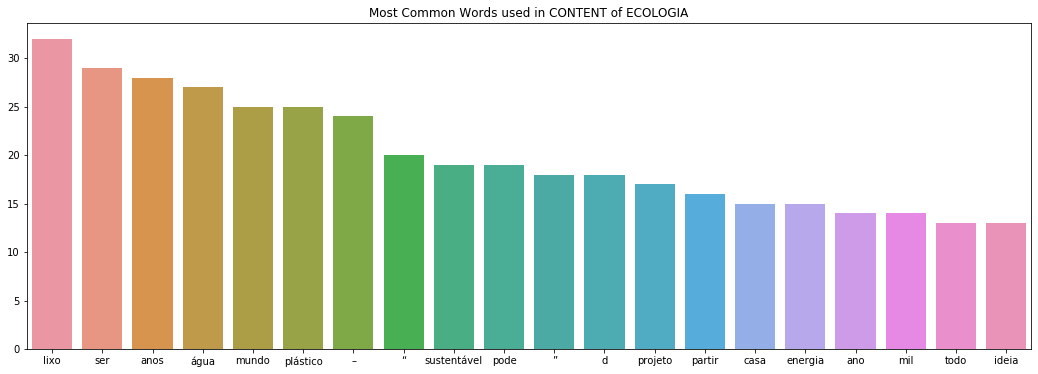

In [147]:
most_common_target_label = train[TARGET_VARIABLE].value_counts().idxmax()
print(most_common_target_label)
most_common_target_text = [str(text) for text in train[train[TARGET_VARIABLE] == most_common_target_label][TEXT_VARIABLE]]
most_common_target_clean = cleanup_text(most_common_target_text)
most_common_target_clean = ' '.join(most_common_target_clean).split()
most_common_target_counts = Counter(most_common_target_clean)
most_common_target_common_words = [word[0] for word in most_common_target_counts.most_common(20)]
most_common_target_common_counts = [word[1] for word in most_common_target_counts.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=most_common_target_common_words, y=most_common_target_common_counts)
plt.title('Most Common Words used in ' + TEXT_VARIABLE + ' of ' + most_common_target_label)
plt.show()

In [150]:
vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,1))
clf = LinearSVC()

pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])
# data
train1 = train[TEXT_VARIABLE].tolist()
labelsTrain1 = train[TARGET_VARIABLE].tolist()
test1 = test[TEXT_VARIABLE].tolist()
labelsTest1 = test[TARGET_VARIABLE].tolist()
# train
pipe.fit(train1, labelsTrain1)
# test
preds = pipe.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print("Top 10 features used to predict: ")
printNMostInformative(vectorizer, clf, 10)

accuracy: 0.40476190476190477
Top 10 features used to predict: 
Class 1 best: 
(-0.16388748360280592, 'nan')
(-0.1365728525205211, 'aprender')
(-0.11547503559416973, 'mãe')
(-0.11206564925547731, 'ribon')
(-0.11176435698265817, 'mundo')
(-0.09185086969560126, 'crianças')
(-0.08344159849899618, 'brasil')
(-0.08055984765322166, 'novembro')
(-0.08011104064919855, 'deveria')
(-0.07928097986012973, 'lugar')
Class 2 best: 
(0.37707075661207545, 'cães')
(0.29860793616218634, 'animais')
(0.2615604670747089, 'elefantes')
(0.2076466726693686, 'pj')
(0.20142225512630488, 'cão')
(0.18909778754033707, 'separados')
(0.18909778754033707, 'lana')
(0.18909778754033707, 'compartilha')
(0.18909778754033707, 'cobertor')
(0.18909778754033707, 'cadelinha')


In [151]:
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer)])
transform = pipe.fit_transform(train1, labelsTrain1)
vocab = vectorizer.get_feature_names()
for i in range(len(train1)):
    s = ""
    indexIntoVocab = transform.indices[transform.indptr[i]:transform.indptr[i+1]]
    numOccurences = transform.data[transform.indptr[i]:transform.indptr[i+1]]
    for idx, num in zip(indexIntoVocab, numOccurences):
        s += str((vocab[idx], num))
        
from sklearn import metrics
print(metrics.classification_report(labelsTest1, preds, 
                                    target_names=df_ribon_news[TARGET_VARIABLE].unique()))

                  precision    recall  f1-score   support

         ANIMAIS       0.64      0.54      0.58        26
   SOLIDARIEDADE       0.25      0.15      0.19        20
         FAMILIA       0.40      0.17      0.24        12
        CRIANCAS       0.00      0.00      0.00         6
       PROPOSITO       0.56      0.33      0.42        30
     DIVERSIDADE       0.42      0.30      0.35        27
        EDUCACAO       0.62      0.78      0.69        41
        ECOLOGIA       0.43      0.39      0.41        23
           SAUDE       0.00      0.00      0.00        15
          IDOSOS       0.50      0.38      0.43         8
         CIENCIA       0.43      0.26      0.32        23
      CELEBRACAO       0.20      0.17      0.18         6
          ETNIAS       1.00      0.25      0.40         4
         ESPORTE       0.35      0.58      0.43        26
         CULTURA       0.00      0.00      0.00         6
EMPREENDEDORISMO       0.22      0.71      0.34        21

        accu

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.pt.stop_words import STOP_WORDS

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

print(STOP_WORDS)

{'debaixo', 'menos', 'um', 'podia', 'relação', 'ir', 'oitava', 'cinco', 'isso', 'quieto', 'se', 'catorze', 'cima', 'nos', 'usa', 'vocês', 'dos', 'teus', 'foste', 'pontos', 'local', 'outra', 'nunca', 'dizem', 'dá', 'teu', 'deste', 'embora', 'puderam', 'fostes', 'após', 'tuas', 'meus', 'estive', 'seus', 'estou', 'estão', 'terceiro', 'caminho', 'zero', 'essas', 'aquelas', 'então', 'depois', 'fará', 'ambos', 'ademais', 'quem', 'põe', 'em', 'meu', 'conhecido', 'antes', 'dois', 'pegar', 'numa', 'área', 'direita', 'cada', 'porquanto', 'porquê', 'tiveste', 'desde', 'iniciar', 'os', 'nós', 'somos', 'vossas', 'fomos', 'fazer', 'nossas', 'saber', 'agora', 'ali', 'sexta', 'são', 'quinto', 'dez', 'duas', 'oito', 'tive', 'meio', 'mesmo', 'fazes', 'alguns', 'estiveram', 'esta', 'estado', 'baixo', 'atrás', 'somente', 'de', 'algo', 'deverá', 'estivestes', 'tem', 'bom', 'parte', 'elas', 'vêm', 'foram', 'esse', 'nesse', 'vós', 'oitavo', 'ela', 'me', 'favor', 'tais', 'dentro', 'número', 'pelos', 'boa', 'q

In [16]:
TARGET_VARIABLE = 'LABEL_TRAIN'
TEXT_VARIABLE = 'TITLE'

newest_doc = df_ribon_news[TEXT_VARIABLE]

doc_list = []
# Iterates through each article in the corpus.
for doc in tqdm(newest_doc):
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(str(doc))
    doc_list.append(pr)

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [50]:
def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them.
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-',
    # so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

nlp = spacy.load(VECTOR_MODEL_NAME)
# The add_pipe function appends our functions to the default pipeline.
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

In [32]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(doc_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

In [33]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=words,
                                        num_topics=10, random_state=2,
                                        update_every=1, passes=10,
                                        alpha='auto', per_word_topics=True)
pprint(lda_model.print_topics(num_words=10))

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/dev/PythonEnviroments/developing-fun/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:734: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generato

[(0,
  '0.054*"o" + 0.014*"e" + 0.007*"história" + 0.007*"pelar" + 0.007*"Congo" + '
  '0.006*"parir" + 0.005*"suar" + 0.005*"amor" + 0.005*"mulher" + '
  '0.005*"milhão"'),
 (1,
  '0.059*"o" + 0.034*"e" + 0.010*"parir" + 0.008*"suar" + 0.006*"ano" + '
  '0.005*"umar" + 0.005*"brasileiro" + 0.005*"negro" + 0.004*"criança" + '
  '0.004*"unir"'),
 (2,
  '0.088*"o" + 0.039*"parir" + 0.028*"e" + 0.008*"ruir" + 0.007*"ajudar" + '
  '0.007*"criança" + 0.007*"pessoa" + 0.005*"criar" + 0.005*"mulher" + '
  '0.004*"transformar"'),
 (3,
  '0.119*"o" + 0.016*"e" + 0.009*"ano" + 0.008*"O" + 0.007*"mulher" + '
  '0.007*"sobrar" + 0.006*"levar" + 0.006*"ajudar" + 0.006*"Ribon" + '
  '0.005*"Brasil"'),
 (4,
  '0.045*"o" + 0.013*"parir" + 0.012*"e" + 0.008*"pelar" + 0.008*"feito" + '
  '0.007*"escola" + 0.007*"mundo" + 0.006*"ruir" + 0.006*"público" + '
  '0.006*"suar"'),
 (5,
  '0.036*"e" + 0.027*"o" + 0.012*"parir" + 0.008*"presentar" + '
  '0.008*"encontrar" + 0.006*"ano" + 0.006*"mulher" + 0.006*"

In [38]:
import pyLDAvis.gensim
# turn on automatic rendering of visualizations
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(lda_model, corpus, words)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.068470  0.056951       1        1  17.065294
3      0.096383 -0.045205       2        1  15.909932
7     -0.008995  0.136511       3        1  10.351353
1     -0.007035 -0.030620       4        1   9.588385
8     -0.083149  0.018970       5        1   9.162425
4      0.033828 -0.025083       6        1   9.011040
6      0.039159 -0.020751       7        1   8.057773
9      0.008574  0.017511       8        1   7.634134
5     -0.119183 -0.016688       9        1   6.830849
0     -0.028053 -0.091596      10        1   6.388814, topic_info=           Term        Freq       Total Category  logprob  loglift
59        parir  142.000000  142.000000  Default  30.0000  30.0000
18            o  503.000000  503.000000  Default  29.0000  29.0000
15            e  158.000000  158.000000  Default  28.0000  28.0000
468       feito   12.000000   12.000000  Default  27.0000  27.0000
381      prêmio   11.000000   11.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1096  periferia    1.326654    4.771336  Topic10  -5.8956   1.4707
979    indígena    1.326625   13.732333  Topic10  -5.8956   0.4135
988      contar    1.326625    5.811878  Topic10  -5.8956   1.2734
45      Conheça    1.326625   15.275844  Topic10  -5.8956   0.3070
312      ganhar    1.326625   15.782136  Topic10  -5.8956   0.2744

[706 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
494       1  0.141395       1
494       2  0.141395       1
494       4  0.141395       1
494       5  0.282790       1
494      10  0.282790       1
...     ...       ...     ...
67        7  0.107715  árvore
67       10  0.215430  árvore
2188      4  0.700980   índio
2309      3  0.920764       🎉
5         5  0.706323       🐶

[1313 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 8, 2, 9, 5, 7, 10, 6, 1])

In [70]:
from nltk.corpus import stopwords
stop_words = stopwords.words('portuguese')
stop_words.extend(['a','o'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod
    
def get_corpus(df, text_label):
    words = [nlp(text) for text in df[text_label].values]
    words = remove_stopwords(words)
    print(words[:-5])
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[word] for word in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text_label) for text_label in bigram]
    return corpus, id2word, bigram

train_corpus, train_id2word, bigram_train = get_corpus(df_ribon_news, TEXT_VARIABLE)
print(train_corpus[:-5])
print(train_id2word)
print(bigram_train[:-5])

['0      0      Há mais de 10 anos, dupla de cães 🐶 aco...\n1      0      Há mais de 10 anos, dupla de cães 🐶 aco...\n2      0      Há mais de 10 anos, dupla de cães 🐶 aco...\n3      0      Há mais de 10 anos, dupla de cães 🐶 aco...\n4      0      Há mais de 10 anos, dupla de cães 🐶 aco...\n                             ...                        \n883    0      Há mais de 10 anos, dupla de cães 🐶 aco...\n884    0      Há mais de 10 anos, dupla de cães 🐶 aco...\n885    0      Há mais de 10 anos, dupla de cães 🐶 aco...\n886    0      Há mais de 10 anos, dupla de cães 🐶 aco...\n887    0      Há mais de 10 anos, dupla de cães 🐶 aco...\nName: TITLE, Length: 888, dtype: object', '0      0      Há mais de 10 anos, dupla de cães 🐶 aco...\n1      0      Há mais de 10 anos, dupla de cães 🐶 aco...\n2      0      Há mais de 10 anos, dupla de cães 🐶 aco...\n3      0      Há mais de 10 anos, dupla de cães 🐶 aco...\n4      0      Há mais de 10 anos, dupla de cães 🐶 aco...\n                           

[['ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'name', 'title', 'length', 'dtype', 'object'], ['ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'name', 'title', 'length', 'dtype', 'object'], ['ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'ano', 'duplo', 'cão', 'aco', 'n